# SHAP를 이용한 모델 예측 결과 해석

SHAP 라이브러리를 사용하여 모델이 **'왜' 특정 플레이어를 치터로 판단했는지** 그 근거를 시각적으로 설명

---

### 주요 동작 흐름

1.  **모델 및 데이터 로드**:
    * 학습한 XGBoost 모델을 로드
    * 분석할 대상의 데이터를 로드
2.  **SHAP 값 계산**:
    * 불러온 모델과 데이터를 사용하여 SHAP Explainer를 생성
    * Explainer를 통해 각 특징이 모델 예측에 미친 영향력을 계산
3.  **결과 분석 및 시각화**:
    * 단일 예측에 대해 각 특징이 긍정적(치터일 확률을 높임) 또는 부정적(사람일 확률을 높임)으로 얼마나 기여했는지 시각화
    * 전체 데이터셋에 걸쳐 어떤 특징이 전역적으로 가장 중요한 영향력을 가졌는지 시각화

---

### 핵심 포인트

* **모델 투명성 확보**: 모델이 단순히 '치터다/아니다'라는 결과만 보여주는 것을 넘어, 어떤 특성이 그러한 판단의 결정적인 근거가 되었는지 설명
* **시각적 근거 제시**: SHAP 플롯을 통해 모델의 복잡한 내부 동작을 직관적으로 이해할 수 있는 시각 자료를 생성

## 라이브러리 설치

In [ ]:
!pip install shap

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
import itertools
import shap
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from scipy.stats import entropy

In [ ]:
drive.mount('/content/drive')

# JavaScript 시각화를 위해 초기화 (Colab에서 필수)
shap.initjs()

Mounted at /content/drive


## 모델 및 데이터 로드

In [ ]:
# --- 불러올 모델의 경로 지정 ---
model_load_path = '/content/drive/MyDrive/Preprocessed_Dataset/xgboost_cheater_detection_model.json'

# --- 모델 로드 ---
model = xgb.XGBClassifier()
model.load_model(model_load_path)

In [ ]:
# --- 불러올 데이터의 경로 지정 ---
human_data_path = "/content/drive/MyDrive/Preprocessed_Dataset/aim_analysis_human.xlsx" # 사람 데이터 엑셀 경로 지정
cheat_data_path = "/content/drive/MyDrive/Preprocessed_Dataset/aim_analysis_cheat.xlsx" # 치트 데이터 엑셀 경로 지정

# --- 엑셀 로드 ---
df_human = pd.read_excel(human_data_path)
df_cheat = pd.read_excel(cheat_data_path)

# --- 치트 라벨 추가 ---
df_human['cheat'] = 0 # 사람 데이터프레임에 모든 행에 'cheat' 컬럼을 추가하고 값을 0으로 설정
df_cheat['cheat'] = 1 # 치트 데이터프레임의 모든 행에 'cheat' 컬럼을 추가하고 값을 1로 설정

In [ ]:
# 두 데이터프레임을 하나로 합침
df_concat = pd.concat([df_human, df_cheat], ignore_index=True)

# 'filename'을 기준으로 데이터를 그룹화
df_grouped = df_concat.groupby('filename')

print(f"총 {len(df_grouped)}개의 고유한 파일이 있습니다.")

총 256개의 고유한 파일이 있습니다.


In [ ]:
# --- 데이터 전처리 ---

'''
01_training_xgboost_model.ipynb와 동일하게 데이터 전처리를 진행
'''

# 파라미터 설정
WINDOW_SIZE = 150  # 150 프레임 (5초)
STEP_SIZE = 30     # 30 프레임 (1초) 만큼 이동 (120 프레임 겹침)
ENTROPY_BINS = 10  # 엔트로피 계산 시 데이터를 나눌 구간(bin) 수

# 요약할 원본 특징 리스트
features_origin_list = ['dx', 'dy', 'velocity', 'acceleration', 'jerk', 'angle_deg', 'angle_change']

# 요약 특징 청크(chunk)를 저장할 리스트
all_video_chunks = []

# 각 영상(파일)별로 반복 처리
for filename, video_data in df_grouped:

    # 해당 영상의 총 프레임 수
    n_frames = len(video_data)

    # 슬라이딩 윈도우 적용
    # 0 프레임부터 (총 프레임 - 윈도우 크기)까지 STEP_SIZE 만큼 이동
    # STEP_SIZE보다 적게 남은 데이터는 버림
    for i in range(0, n_frames - WINDOW_SIZE + 1, STEP_SIZE):

        # 150 프레임으로 구성된 현재 윈도우(청크)를 추출
        chunk = video_data.iloc[i : i + WINDOW_SIZE]

        # 현재 청크의 요약 특징을 저장할 딕셔너리
        summary_stats = {}

        # 기본 정보(파일이름, 치트여부) 추가
        summary_stats['filename'] = filename
        # cheat 값은 윈도우 내에서 동일하므로 첫 번째 값을 사용
        summary_stats['cheat'] = chunk['cheat'].iloc[0]
        summary_stats['start_frame'] = i

        # --- 각 특징별로 요약 특징 계산 ---
        for col in features_origin_list:
            series = chunk[col] # 현재 청크의 해당 특징(Series)

            # --- 요약 특징 계산 ---
            summary_stats[f'{col}_mean'] = series.mean()          # 평균
            summary_stats[f'{col}_median'] = series.median()      # 중앙값

            # mode는 여러 개일 수 있으므로 첫 번째 값만 사용 (없으면 NaN)
            mode_val = series.mode()
            summary_stats[f'{col}_mode'] = mode_val.iloc[0] if not mode_val.empty else np.nan

            s_max = series.max()
            s_min = series.min()
            summary_stats[f'{col}_range'] = s_max - s_min         # 범위
            summary_stats[f'{col}_std'] = series.std()            # 표준편차

            q75 = series.quantile(0.75)
            q25 = series.quantile(0.25)
            summary_stats[f'{col}_iqr'] = q75 - q25               # 사분위수 범위

            summary_stats[f'{col}_max'] = s_max                   # 최댓값
            summary_stats[f'{col}_min'] = s_min                   # 최솟값
            summary_stats[f'{col}_skewness'] = series.skew()      # 왜도
            summary_stats[f'{col}_kurtosis'] = series.kurtosis()  # 첨도

            s_np = series.values
            summary_stats[f'{col}_zcr'] = ((s_np[:-1] * s_np[1:]) < 0).sum() / WINDOW_SIZE  # 영점 교차율

            # 데이터를 구간으로 나눔
            binned_series = pd.cut(series, bins=ENTROPY_BINS, labels=False)
            # 각 구간의 빈도수를 계산
            value_counts = binned_series.value_counts(normalize=True)
            summary_stats[f'{col}_entropy'] = entropy(value_counts)                         # 엔트로피

        # --- 모든 특징 조합의 상관계수 계산 ---
        for feat1, feat2 in itertools.combinations(features_origin_list, 2):
            correlation = chunk[feat1].corr(chunk[feat2])

            # 한쪽 값이 일정(std=0)하면 상관계수가 NaN이 됨 -> 0으로 처리
            if pd.isna(correlation):
                summary_stats[f'corr_{feat1}_{feat2}'] = 0
            else:
                summary_stats[f'corr_{feat1}_{feat2}'] = correlation

        # 완성된 요약 특징 딕셔너리를 리스트에 추가
        all_video_chunks.append(summary_stats)

# 모든 청크 리스트를 하나의 새로운 DataFrame으로 변환
df = pd.DataFrame(all_video_chunks)

In [ ]:
# --- 특징 및 라벨 분리 ---
y_test_df = df['cheat'] # 'cheat' 열을 라벨로 사용
groups = df['filename'] # 데이터를 나눌 기준 (파일 이름)
non_feature_cols = ['filename', 'cheat', 'start_frame'] # 특징이 아닌 열들
X_test_df = df.drop(columns=non_feature_cols)           # 구별자를 제외하여 데이터셋 생성

print("--- 전체 데이터셋 (X_test_df) ---")
print(f"총 데이터(청크) 수: {len(X_test_df)}")
print(f"총 특징 수: {X_test_df.shape[1]}")

--- 전체 데이터셋 (X_test_df) ---
총 데이터(청크) 수: 5569
총 특징 수: 105


## SHAP 값 계산

In [ ]:
# --- SHAP Explainer 생성 ---
explainer = shap.TreeExplainer(model)

In [ ]:
# --- SHAP 값 계산 ---
shap_values = explainer.shap_values(X_test_df)

In [ ]:
# --- SHAP Interaction 값 계산 ---
# 전체 데이터셋을 사용하면 계산량이 엄청나게 많아 매우 오래 걸릴 수 있음
'''
shap_interaction_values = explainer.shap_interaction_values(X_test_df)
'''

# 샘플링으로 데이터셋 줄이기
X_test_sample = X_test_df.sample(100, random_state=42)
shap_interaction_values_sample = explainer.shap_interaction_values(X_test_sample)

## 결과 분석 및 시각화

In [ ]:
# --- 고유한 파일 이름 리스트에서 랜덤으로 1개 선택 ---
unique_files = df['filename'].unique()
rng = np.random.default_rng(seed=42)
target_filename = rng.choice(unique_files)

# --- 해당 파일에 속하는 '원본 df 기준 인덱스' 리스트 생성 ---
TARGET_INDICES_LIST = df[df['filename'] == target_filename].index.tolist()
num_chunks_in_file = len(TARGET_INDICES_LIST)

# --- 선택된 파일 정보 출력 ---
file_info = df.loc[TARGET_INDICES_LIST[0]] # 첫 번째 청크 정보로 라벨 확인
actual_label = "Cheater (1)" if file_info['cheat'] == 1 else "Human (0)"

print(f"--- 랜덤 분석 대상 파일: {target_filename} ---")
print(f"  총 청크 수: {num_chunks_in_file}")
print(f"  실제 라벨: {actual_label}")
print("-" * 30)
print(f"해당 파일의 청크 인덱스 (X_test_df 기준):")
print(TARGET_INDICES_LIST)

--- 랜덤 분석 대상 파일: cheats/cf504c19-257a-4dbe-a93b-77e139a91646.webm ---
  총 청크 수: 22
  실제 라벨: Cheater (1)
------------------------------
해당 파일의 청크 인덱스 (X_test_df 기준):
[485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506]


In [ ]:
# --- 분석할 청크의 '순번' 지정 ---
CHUNK_ITERATOR_INDEX = 0

# --- 유효성 검사 ---
if 'TARGET_INDICES_LIST' not in locals():
    print("오류: TARGET_INDICES_LIST 변수가 정의되지 않았습니다.")
elif CHUNK_ITERATOR_INDEX >= len(TARGET_INDICES_LIST) or CHUNK_ITERATOR_INDEX < 0:
    print(f"오류: 인덱스 {CHUNK_ITERATOR_INDEX}가 유효하지 않습니다.")
    print(f"유효한 순번(ITERATOR) 범위: 0 ~ {len(TARGET_INDICES_LIST) - 1}")
else:
    # --- 실제 데이터 인덱스 가져오기 ---
    # 리스트에서 '순번'에 해당하는 '실제 인덱스'를 조회
    actual_df_index = TARGET_INDICES_LIST[CHUNK_ITERATOR_INDEX]

    # --- 해당 청크 정보 확인 ---
    selected_chunk_info = df.loc[actual_df_index]
    selected_start_frame = selected_chunk_info['start_frame']

    print(f"--- 파일 '{target_filename}'의 {CHUNK_ITERATOR_INDEX}번째 청크 분석 ---")
    print(f"  (실제 인덱스: {actual_df_index} / 시작 프레임: {selected_start_frame})")
    print("-" * 30)

    # --- SHAP Explanation 객체 생성 ---
    # '전체' shap_values에서 'actual_df_index'번째 값만 사용
    explanation_chunk = shap.Explanation(
        values=shap_values[actual_df_index],
        base_values=explainer.expected_value,
        data=X_test_df.iloc[actual_df_index],
        feature_names=X_test_df.columns
    )

--- 파일 'cheats/cf504c19-257a-4dbe-a93b-77e139a91646.webm'의 0번째 청크 분석 ---
  (실제 인덱스: 485 / 시작 프레임: 0)
------------------------------


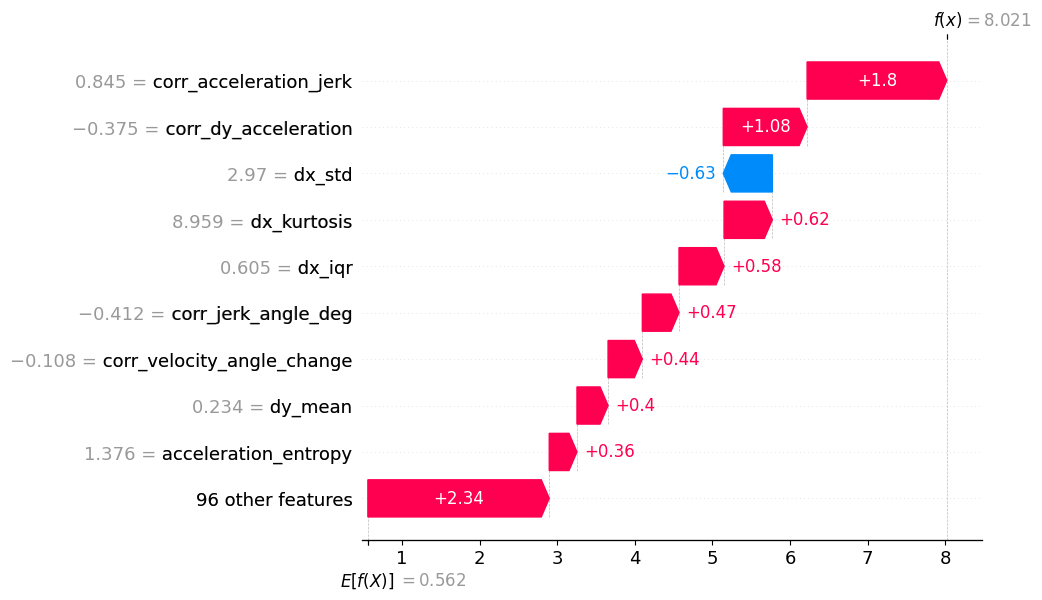

In [ ]:
# --- Waterfall Plot ---
shap.plots.waterfall(explanation_chunk)
plt.show()

In [ ]:
# JavaScript 시각화를 위해 초기화 (Colab에서 필수)
shap.initjs()

# --- Force Plot ---
shap.plots.force(explainer.expected_value,
                 shap_values[actual_df_index],
                 X_test_df.iloc[actual_df_index])

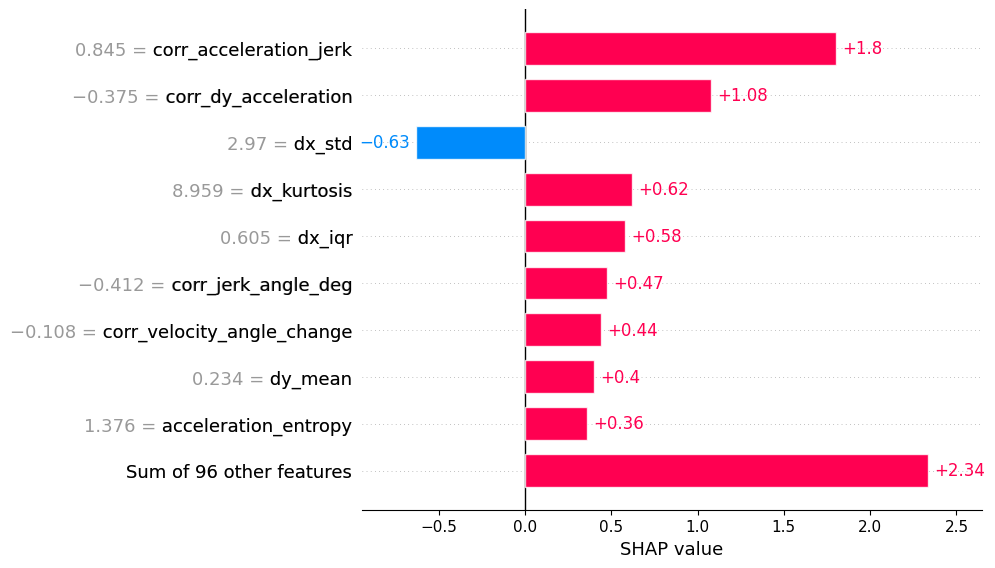

In [ ]:
# --- Bar Plot ---
shap.plots.bar(explanation_chunk)
plt.show()

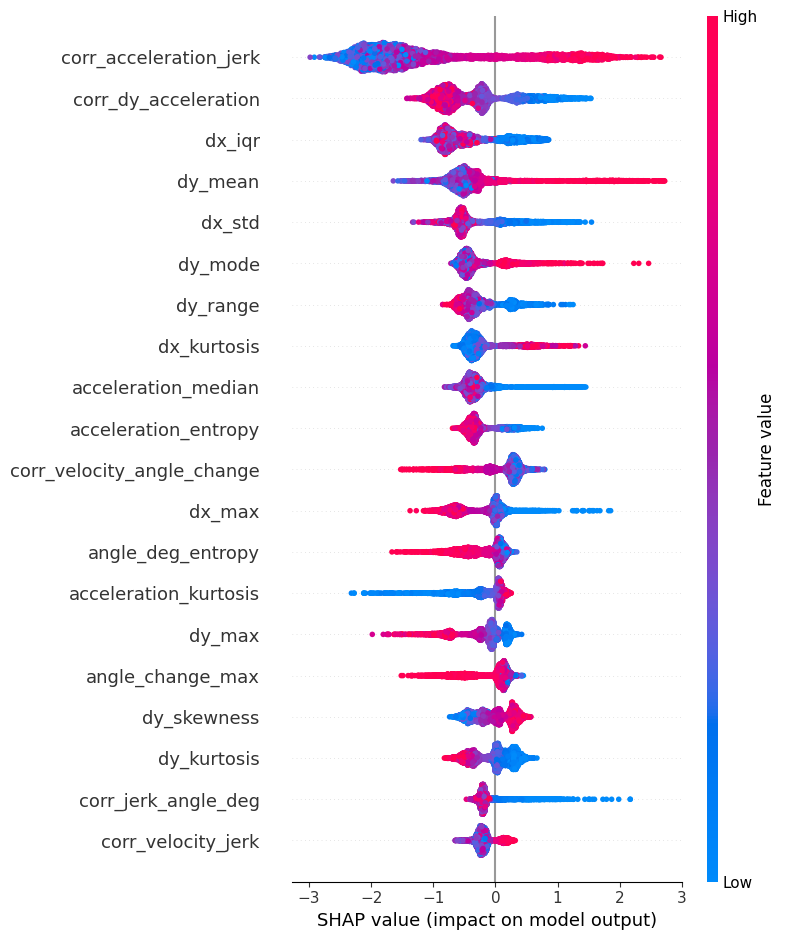

In [ ]:
# --- 모델 전체 경향성 분석 ---
shap.summary_plot(shap_values, X_test_df)
plt.show()

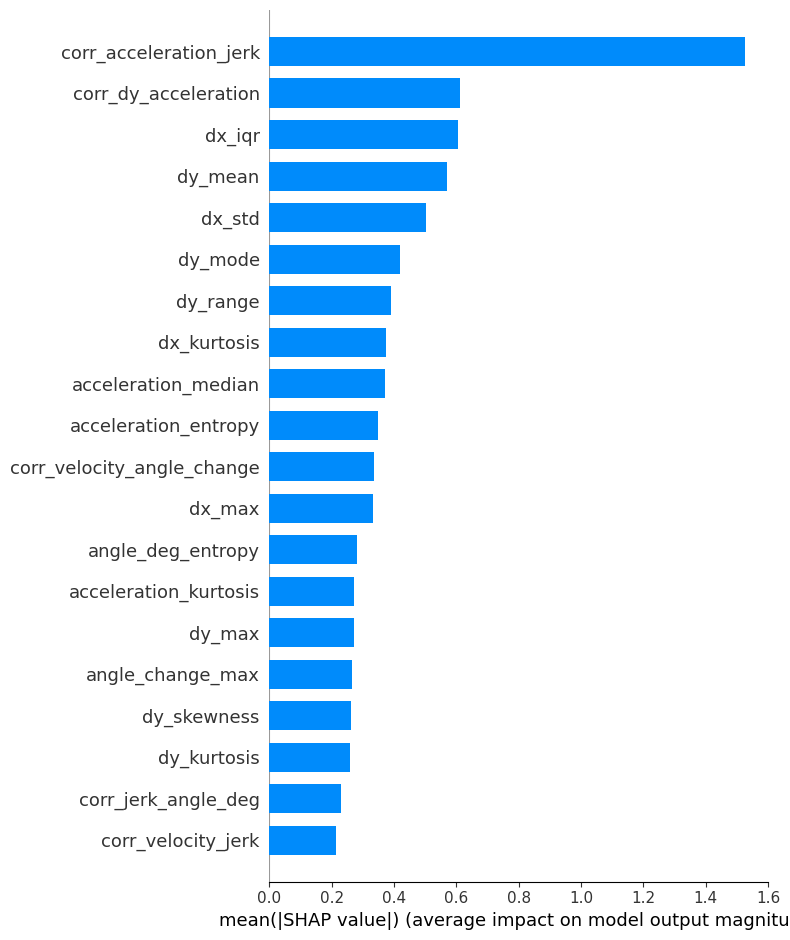

In [ ]:
shap.summary_plot(shap_values, X_test_df, plot_type="bar")
plt.show()

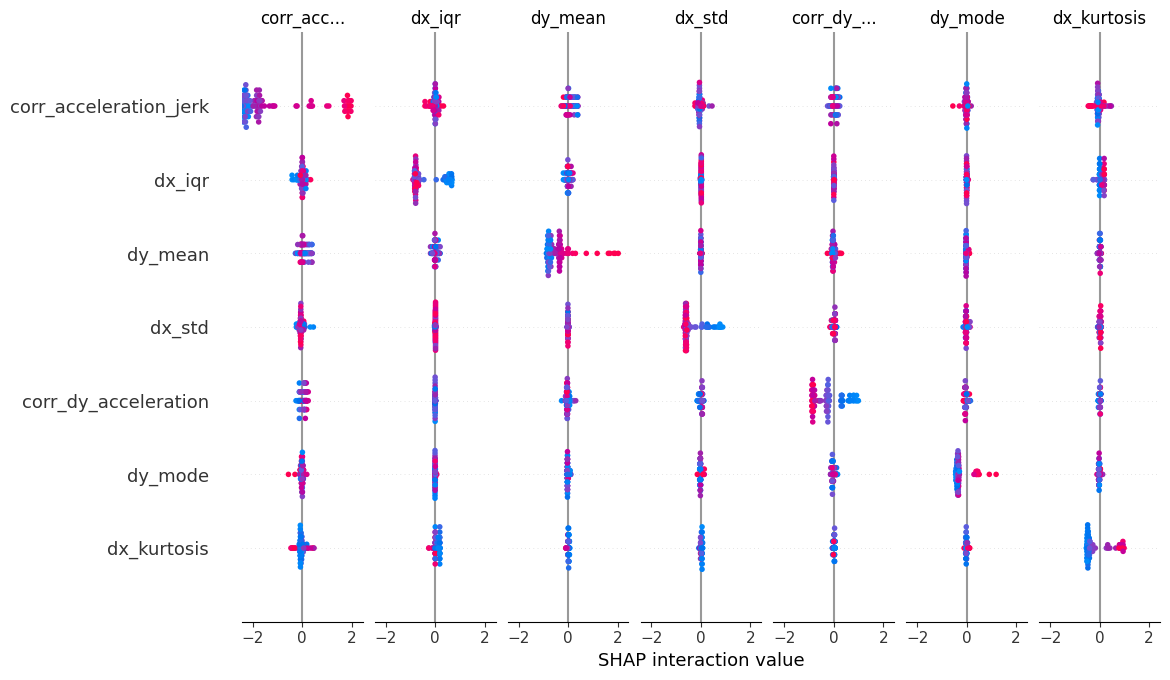

In [ ]:
# 전체 데이터셋 버전
'''
shap.summary_plot(shap_interaction_values, X_test_df)
plt.show()
'''

# 샘플링 버전
shap.summary_plot(shap_interaction_values_sample, X_test_sample)
plt.show()